In [1]:
import tensorflow as tf
import numpy as np
from samplers import *
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import linear_model
import copy
import scipy.stats
import itertools
import os
import time
sess = tf.InteractiveSession()

In [2]:
D =   2 
N = 1000
sigma=1
c=0.1

# Generate y since y~N(W0*W1*,1) where W0*=W1*=0
y=sigma*np.random.randn(N)
base=np.float64
tfbase=tf.float64
train_labels = np.expand_dims(y,1).astype(base)

# Generate an empty np.array simply because it is a required parameter in run sampler, 
# but we do not need it when calculating gradients 
data = np.empty([N,D])
labels = train_labels
def test_error():
    return 0

In [3]:
xPH = tf.placeholder(tfbase, [None,D])
yPH = tf.placeholder(tfbase, [None,1],)
W = tf.Variable(tf.zeros([D,1],tfbase),tfbase)
all_weights = [W]
w_shapes = [W.get_shape()]

lamb0=tf.Variable(tf.ones([100,1],tfbase),tfbase)
lamb1=tf.Variable(tf.ones([100,1],tfbase),tfbase)

In [4]:
# Create the negative likelihood function based on the log posterior formula
NLL=tf.reduce_mean((yPH-(lamb0*W[0,0])*(lamb1*W[1,0]))**2/(2*(sigma**2)))+c*((lamb0*W[0,0])**2+(lamb1*W[1,0])**2)/(2*N)

# Update weights based on the new gradient (which is g=vt getting from SBPS.update()) 
# and Negative log likelihood using tf.train.GradientDescentOptimzer
opt = tf.train.GradientDescentOptimizer(learning_rate=1)
grads_and_vars = opt.compute_gradients(NLL,var_list=W)
gradients, variables = zip(*grads_and_vars)
weights = tf.reshape(variables[0],[D])
gPH = tf.placeholder(tfbase,[D])
grads_to_apply = []
grads_to_apply.append(tf.reshape(gPH,[D,1]))
grad_and_vars_to_apply=list(zip(grads_to_apply, variables))
tf_train_step = opt.apply_gradients(grad_and_vars_to_apply)

vPH=tf.placeholder(tfbase,[D])

# Get the average gradient of lamb using opt.compute_gradients 
# and then calculate the gradients of W for each y under the condition of lamb=1
opt1 = tf.train.GradientDescentOptimizer(learning_rate=1)
gradslamb0_and_vars = opt1.compute_gradients(NLL, var_list=lamb0)
gradientslamb0, variableslamb0 = zip(*gradslamb0_and_vars)
gradient_w0 = gradientslamb0[0]/(W[0,0])
gradslamb1_and_vars = opt1.compute_gradients(NLL, var_list=lamb1)
gradientslamb1, variableslamb1 = zip(*gradslamb1_and_vars)
gradient_w1 = gradientslamb1[0]/(W[1,0])
gradient_explicit=tf.concat([gradient_w0, gradient_w1],1)
tf_grad_calc=tf.reduce_mean(gradient_explicit,0)

# calculate the sample variance of the mini-batch
better_gradient_variance_intermediate=tf.matmul(gradient_explicit,tf.reshape(vPH,[D,1]))
tf_grad_var_calc=tf.nn.moments(better_gradient_variance_intermediate,[0])[1]

In [5]:
# wrapping tf functions to pass to run_sampler and generate_sbps_samples
def grad_calc(data,labels):
    return tf_grad_calc.eval(feed_dict={xPH: data, yPH: labels})
def grad_var_calc(data,labels,v):
    return tf_grad_var_calc.eval(feed_dict={xPH: data, yPH: labels, vPH: v})
def train_step(g):
    return tf_train_step.run(feed_dict={gPH: g})
weights = flatten_tensor_list(all_weights)
def get_weights():
    return weights.eval()

# function to assign weights
assign_weights_ops = []
curr_ind = 0
w_to_assign = tf.placeholder(tfbase,[D],name='w_to_assign')
for [weight,shape] in zip(all_weights,w_shapes):
    assign_weights_ops.append(weight.assign(tf.reshape(w_to_assign[curr_ind:curr_ind + int(np.prod(shape))],shape)))
    curr_ind += int(np.prod(shape))
def set_weights(w):
    for a_w in assign_weights_ops:
        sess.run(a_w,feed_dict={w_to_assign:w})


In [6]:
sess.run(tf.global_variables_initializer())
# run samplers
n_epochs=1000
batch_size=100
total_iter=n_epochs*(N/batch_size)
NLL_factor = total_iter
print('Running ' + str(n_epochs) + ' epochs (' +str(total_iter) + ' iterations) per method')


W_start = np.array([-3.11,0.01])
k = 3
plt_labels = []
trajectories = []
NLLs = []

# SBPS
k = 3
print('Running SBPS, k = ' + str(k))
sess.run(tf.initialize_all_variables())
my_SBPS = SBPS(D,N,batch_size,k)
NLL_SBPS_0,samples_SBPS_0 = run_sampler(my_SBPS,get_weights,set_weights,\
                                                       test_error,total_iter,n_epochs,NLL_factor,\
                                                       data,labels,batch_size,grad_calc,\
                                                       train_step,grad_var_calc,W_init=W_start)
NLL_SBPS,samples_SBPS = generate_SBPS_samples(my_SBPS,get_weights,set_weights,test_error,\
                                                train_step,NLL_factor,W_init=W_start)


#NLL_SBPS_0,acc_SBPS,samples_SBPS_0 = runOptimizationExplicit(my_SBPS,0,W_start)
#NLL_SBPS,samples_SBPS = generate_SBPS_samples(my_SBPS,W_start,W,N)
my_SBPS.print_summary()
plt_labels.append('SBPS')
trajectories.append(samples_SBPS)
NLLs.append(NLL_SBPS)


Running 1000 epochs (10000.0 iterations) per method
Running SBPS, k = 3
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Evaluating Test error / NLL -  0
Evaluating Test error / NLL -  0
Time elapsed -  23.5679  secs ( 0.392798  mins)
Warning - minibatch variance smaller than  1e-15  calculated  1  times. Consider increasing minibatch size.
Generating discrete samples from continuous SBPS trajectory
Evaluating Test error -  0
Number of bounces: 1602
percent p(acc)>1:  0.05118601747815231
percent rejections:  0.8398
percent negative slope:  0.0136
total travel time:  80.9631585419
max trajectories:  0
refreshments: 1


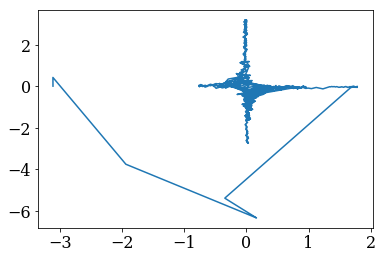

In [7]:
#Creat the plot of w0 and w1
plt.rcParams['font.size'] = 16
plt.rcParams['font.family']='serif'
plt.rcParams['mathtext.default']='regular'
plt.plot(trajectories[0][:-1,0],trajectories[0][:-1,1],label=plt_labels[0])